# Simulated annealing metaheuristic to optimize the QAP

This SA code is designed to handle one of the discrete optimization (combinatorial) problems, specifically the QAP

Coded by: Mohammed Alagha

October 2020

The quadratic assignment problem (QAP) is one of the fundamental combinatorial optimization problems in the branch of optimization or operations research in mathematics, from the category of the facilities location problems first introduced by Koopmans and Beckmann.

For more information, please check this Wikipedia link

https://en.wikipedia.org/wiki/Quadratic_assignment_problem


The example and code idea are adopted from "Optimization with Metaheuristics in Python", a course offered on Udemy 
however some modifications are made to replace a lengthy code block by breaking it down to useful functions

# Input data

In [123]:
# Importing relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as time

# Defining dataframes for distance and flow
Distance = pd.DataFrame([[0,1,2,3,1,2,3,4],[1,0,1,2,2,1,2,3],
                         [2,1,0,1,3,2,1,2],[3,2,1,0,4,3,2,1],
                         [1,2,3,4,0,1,2,3],[2,1,2,3,1,0,1,2],
                         [3,2,1,2,2,1,0,1],[4,3,2,1,3,2,1,0]], 
                         columns = ["A", "B", "C", "D", "E", "F", "G", "H"],
                         index = ["A", "B", "C", "D", "E", "F", "G", "H"])


Flow = pd.DataFrame([[0,5,2,4,1,0,0,6],[5,0,3,0,2,2,2,0],
                     [2,3,0,0,0,0,0,5],[4,0,0,0,5,2,2,10],
                     [1,2,0,5,0,10,0,0],[0,2,0,2,10,0,5,1],
                     [0,2,0,2,0,5,0,10],[6,0,5,10,0,1,10,0]],
                     columns = ["A", "B", "C", "D", "E", "F", "G", "H"],
                     index = ["A", "B", "C", "D", "E", "F", "G", "H"])

# Initial Conditions, Parameters & Hyper-parameters intialization

Since Simulated annealing is a neighborhood-search algorithm, it needs starting points (i.e., initial conditions)

In [133]:
# Hyperparameters of the Simulated Annealing algorithm

# Starting tempreature
T0 = 1500

# Number of iterations
M = 250 

# Number of neighbors explored at each iteration
N = 20

# Cooling rate. Amount by which T0 decreases each iteration m in M
alpha = 0.9

# Initial Solution
X0 = ["B","D","A","E","C","F","G","H"]
print("The size of the solution vector is: " +str(len(X0)))

The size of the solution vector is: 8


# Useful functions

In [96]:
def swap(X0):
    '''
    This function swaps two variables and creates a challenging solution vector
    
    Input:
    
    X0: The incumbent solution vector
    
    Output:
    X_temp: The challenging solution vector
    '''
    # Generate two random integers with a range between 0 and the size of the solution vector
    # The two random integers should be different, otherwise we will end up swapping the same variable with itself
    rand_1 = np.random.randint(0, len(X0))
    rand_2 = np.random.randint(0, len(X0))
    
    while rand_1 == rand_2:
        rand_2 = np.random.randint(0, len(X0))
        
    # Define a temporary vector to contain the challenging solution
    X_temp = []
    
    # two positions (variables/departments) to be swapped (chosen at random)
    Pos_1 = X0[rand_1]
    Pos_2 = X0[rand_2]
        
    # initiate swapping process
    a = 0
    for b in range(len(X0)):
        if X0[a] == X0[rand_1]:
            X_temp = np.append(X_temp, X0[rand_2])
        elif X0[a] == X0[rand_2]:
            X_temp = np.append(X_temp, X0[rand_1])
        else:
            X_temp = np.append(X_temp, X0[a])
        a += 1
    
    return X_temp

In [97]:
def compute_OF(Distance, Flow, X):
    '''
    This function computes the objective function value
    
    Input:
    Distance: Dataframe (symmetric) of the distances between department
    Flow: Dataframe (symmetric) of the flows between departments
    X0: Current best solution (Incumbent)
    
    Output:
    objective function value
    '''
    
    Dist_DF   = Distance.reindex(columns = X, index = X)
    Dist_array  = np.array(Dist_DF)
    assert(Dist_array.shape == (len(X), len(X)))
    
    
    Obj_Function        = pd.DataFrame(Dist_array * Flow)
    Obj_Function_arr    = np.array(Obj_Function)
    assert(Obj_Function_arr.shape == (len(X), len(X)))
    
    OF_value  = sum(sum(Obj_Function_arr))
    assert(OF_value.shape == ())
    
    return OF_value

In [98]:
def temp_cycle(challenge_z, Incumbent_z, T0, X_temp, X0):
    """
    This function randomly takes the decision of updating the current incumbent solution vector
    
    Input:
    challenge_z: challenging Obj. function value
    Incumbent_z:
    T0: Current temperature
    X_temp: challenging solution vector
    X0: Incumbent solution vector
    
    Output:
    Updated Incumbent solution vector
    
    """
    
    prob = np.random.rand()
        
    # Decision formula
    Decision = 1/(np.exp(challenge_z - Incumbent_z) / T0)
        
    if challenge_z <= Incumbent_z:
        X0 = X_temp
    elif prob <= Decision:
        X0 = X_temp
    else:
        X0 = X0 
    return X0

# Algorithm body

In [129]:
def SA_QAP(Distance, Flow, X0, T0, M, N, alpha):
    '''
    This function combines the previous functions and executes the complete routine of the simulated annealing 
    algorithm for the QAP (combinatorial/discrete optimization problem)
    
    Input:
    Distance: Dataframe (symmetric) of the distances between department
    Flow: Dataframe (symmetric) of the flows between departments
    X0: Current best solution (Incumbent)
    T0: Initial temperature
    M: Number of iterations
    N: Number of explored neighbors
    alpha: Factor by which T0 decreases each iteration m in M
    
    Output:
    Results: Dictionary containing:
            1- final temperature
            2- best heuristically achieved Z value
            3- all temperatures throughout the iterations
            4- all z values (for plotting purposes)
            5- incumbent solution vector
    '''
    
    temp = []
    z_value = []
    Incumbent_z = compute_OF(Distance, Flow, X0)

    print("-------------- Before Optimization ----------------")
    print("Initial Solution X0 = ", X0)
    print("Initial objective value for z = " + str(Incumbent_z))

    for i in range(M):
        for j in range(N):

            # Create the challening solution by swapping variables in the incumbent solution vector X0
            X_temp = swap(X0)
            

            # Computing the OF of the current best solution (Incumbent)
            Incumbent_z = compute_OF(Distance, Flow, X0)
            challenge_z = compute_OF(Distance, Flow, X_temp)

            # Randomly decide whether to make the swap or not
            X0 = temp_cycle(challenge_z, Incumbent_z, T0, X_temp, X0)

        # Append temperature and associated best iteration z-value
        temp.append(T0)
        z_value.append(Incumbent_z)

        # Update temperature
        T0 = alpha * T0
    
    # A dictionary to save results
    Results = {"T_final": T0,
               "Min_z": Incumbent_z,
               "temp": temp,
               "z_value": z_value,
               "Incumbent": X0}
    
    print()
    print("-------------- After Optimization ----------------")
    print("Incumbent Solution = ", X0)
    print("Incumbent objective value for z = " + str(Incumbent_z))
    print()
    
    return Results

# Experimentation

In [131]:
# Starting time
tic = time.time()

# Execution
SA_QAP_optimized = SA_QAP(Distance, Flow, X0, T0, M, N, alpha)

# Ending time
toc = time.time()

print("Running time = %0.3f" %(toc - tic) + " seconds")

-------------- Before Optimization ----------------
Initial Solution X0 =  ['B', 'D', 'A', 'E', 'C', 'F', 'G', 'H']
Initial objective value for z = 336

-------------- After Optimization ----------------
Incumbent Solution =  ['B' 'A' 'E' 'C' 'D' 'H' 'G' 'F']
Incumbent objective value for z = 214

Running time = 19.907 seconds


# Plotting

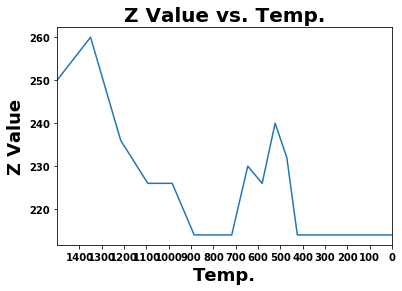

In [132]:
# Plotting functions completely copied from the course code since the code is simple and straight forward
# The only change is the input to the plot function which are the dictionary ouptputs of the algorithm body 

plt.plot(SA_QAP_optimized["temp"], SA_QAP_optimized["z_value"])
plt.title("Z Value vs. Temp.", fontsize = 20, fontweight = 'bold')
plt.xlabel("Temp.", fontsize = 18, fontweight = 'bold')
plt.ylabel("Z Value", fontsize = 18, fontweight = 'bold')
plt.xlim(1500, 0)

plt.xticks(np.arange(min(SA_QAP_optimized["temp"]), max(SA_QAP_optimized["temp"]), 100), fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.show()